In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors

### Discriminant analysis

In [2]:
cmap = colors.LinearSegmentedColormap(
    "red_blue_classes",
    {
        "red": [(0, 1, 1), (1, 0.7, 0.7)],
        "green": [(0, 0.7, 0.7), (1, 0.7, 0.7)],
        "blue": [(0, 0.7, 0.7), (1, 1, 1)],
    },
)
plt.cm.register_cmap(cmap=cmap)

In [3]:
def dataset_fixed_cov():
    """Generate 2 Gaussians samples with the same covariance matrix"""
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0.0, -0.5], [1, 0.5]])
    X = np.r_[
        np.dot(np.random.randn(n, dim), C),
        np.dot(np.random.randn(n, dim), C) + np.array([1, 1]),
    ]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y


def dataset_cov():
    """Generate 2 Gaussians samples with different covariance matrices"""
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0.0, -1.0], [2.5, 1.0]]) * 3.0
    X = np.r_[
        np.dot(np.random.randn(n, dim), C),
        np.dot(np.random.randn(n, dim), C.T) + np.array([0, 4]),
    ]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y

In [4]:
from scipy import linalg


def plot_data(lda, X, y, y_pred, fig_index):
    splot = plt.subplot(2, 2, fig_index)
    if fig_index == 1:
        plt.title("Linear Discriminant Analysis")
        plt.ylabel("Same covariance matrix in both groups")
    elif fig_index == 2:
        plt.title("Quadratic Discriminant Analysis")
    elif fig_index == 3:
        plt.ylabel("Different covariance matrices")

    tp = y == y_pred  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    # class 0: dots
    plt.scatter(X0_tp[:, 0], X0_tp[:, 1], marker=".", color="red")
    plt.scatter(X0_fp[:, 0], X0_fp[:, 1], marker="x", s=20, color="#990000")  # dark red

    # class 1: dots
    plt.scatter(X1_tp[:, 0], X1_tp[:, 1], marker=".", color="blue")
    plt.scatter(X1_fp[:, 0], X1_fp[:, 1], marker="x", s=20, color="#000099")  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(
        xx, yy, Z, cmap="red_blue_classes", norm=colors.Normalize(0.0, 1.0), zorder=0
    )
    plt.contour(xx, yy, Z, [0.5], linewidths=2.0, colors="white")

    # means
    plt.plot(
        lda.means_[0][0],
        lda.means_[0][1],
    )
    plt.plot(
        lda.means_[1][0],
        lda.means_[1][1],
    )

    return splot


def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(
        mean,
        2 * v[0] ** 0.5,
        2 * v[1] ** 0.5,
        180 + angle,
        facecolor=color,
        edgecolor="black",
        linewidth=2,
    )
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.2)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())


def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, "red")
    plot_ellipse(splot, lda.means_[1], lda.covariance_, "blue")


def plot_qda_cov(qda, splot):
    plot_ellipse(splot, qda.means_[0], qda.covariance_[0], "red")
    plot_ellipse(splot, qda.means_[1], qda.covariance_[1], "blue")

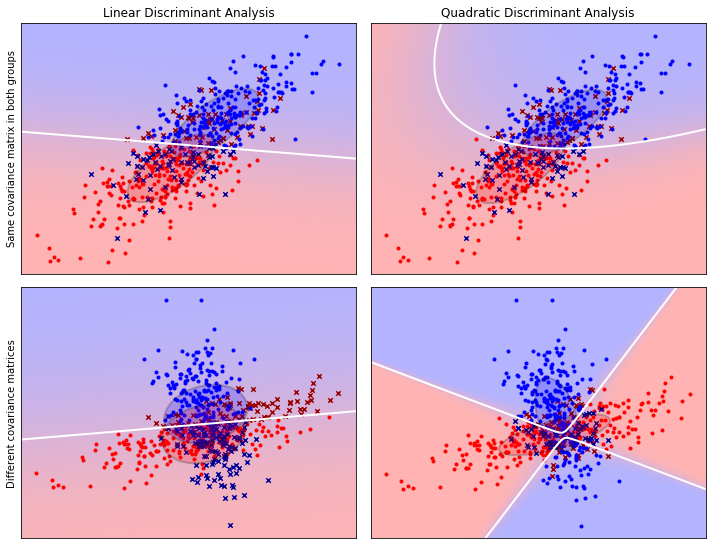

In [5]:
plt.figure(figsize=(10, 8), facecolor="white")

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

for i, (X, y) in enumerate([dataset_fixed_cov(), dataset_cov()]):
    # Linear Discriminant Analysis
    lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
    y_pred = lda.fit(X, y).predict(X)
    splot = plot_data(lda, X, y, y_pred, fig_index=2 * i + 1)
    plot_lda_cov(lda, splot)
    plt.axis("tight")

    # Quadratic Discriminant Analysis
    qda = QuadraticDiscriminantAnalysis(store_covariance=True)
    y_pred = qda.fit(X, y).predict(X)
    splot = plot_data(qda, X, y, y_pred, fig_index=2 * i + 2)
    plot_qda_cov(qda, splot)
    plt.axis("tight")

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

### Logistic regression

In [6]:
# ignore warnings for better clarity (may not be the best thing to do)...
import warnings
warnings.filterwarnings('ignore')

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
# Required packages
np.set_printoptions(precision=2) 
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn
from numpy.linalg import norm
from scipy.optimize import check_grad
import seaborn as sns

$\rightharpoondown$ The objective is to predict the  label $Y\in\{0,1\}$ based on $X\in\mathbb{R}^d$.

$\rightharpoondown$ Logistic regression models the distribution of $Y$ given $X$.

\begin{equation*}
\mathbb{P}(Y = 1| X) = \sigma(\langle w,X \rangle + b)\,,
\end{equation*}
where $w \in \mathbb{R}^d$ is a vector of model weights and $b \in \mathbb{R}$ is the intercept, and where $\sigma$ is the sigmoid function.

$$
\sigma: z \mapsto \frac{1}{1 + e^{-z}}\,.
$$

$\rightharpoondown$ The sigmoid function is a model choice to map $\mathbb{R}$ into $(0,1)$.

In [9]:
def sigmoid(x):
    expx = np.exp(x)
    z   = expx / (1. + expx)
    return z

def sample_logistic(w0, n_samples=1000, corr=0.5):
    n_features = w0.shape[0]
    cov        = toeplitz(corr ** np.arange(0, n_features))
    X          = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p          = sigmoid(X.dot(w0))
    y          = np.random.binomial(1, p, size=n_samples)
    return X, y

def decision_function(X,w):
    z = sigmoid(X.dot(w))
    return z

In [10]:
n_samples  = 1000
n_features = 2

w0   = multivariate_normal([-2,1], np.eye(2))
X, y = sample_logistic(w0, n_samples=n_samples, corr = 0.3)

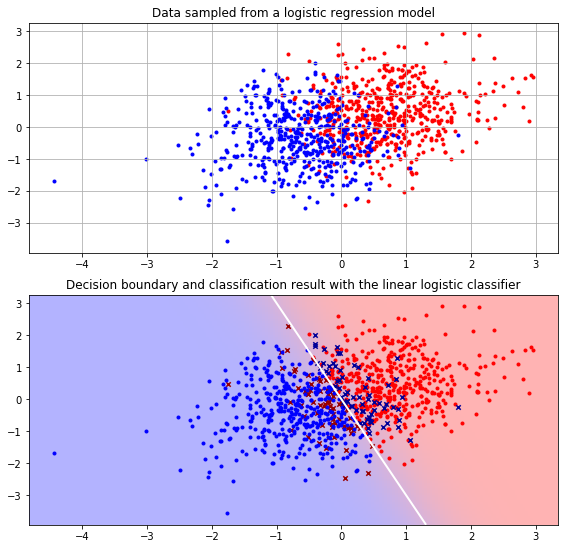

In [11]:
y_pred = decision_function(X,w0)>0.5

tp = y == y_pred  # True Positive
tp0, tp1 = tp[y == 0], tp[y == 1]
X0, X1 = X[y == 0], X[y == 1]
X0_tp, X0_fp = X0[tp0], X0[~tp0]
X1_tp, X1_fp = X1[tp1], X1[~tp1]

plt.figure(figsize = (8,8))
plt.subplot(2, 1, 1)
plt.title("Data sampled from a logistic regression model")
# class 0: dots
plt.scatter(X0[:, 0], X0[:, 1], marker=".", color="red")
# class 1: dots
plt.scatter(X1[:, 0], X1[:, 1], marker=".", color="blue")
plt.axis("tight")
plt.grid(b=None)

plt.subplot(2, 1, 2)
plt.title("Decision boundary and classification result with the linear logistic classifier")

# class 0: dots
plt.scatter(X0_tp[:, 0], X0_tp[:, 1], marker=".", color="red")
plt.scatter(X0_fp[:, 0], X0_fp[:, 1], marker="x", s=20, color="#990000")  # dark red

# class 1: dots
plt.scatter(X1_tp[:, 0], X1_tp[:, 1], marker=".", color="blue")
plt.scatter(X1_fp[:, 0], X1_fp[:, 1], marker="x", s=20, color="#000099")  # dark blue

# class 0 and 1 : areas
nx, ny = 200, 100
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
xy     = np.vstack([xx.ravel(), yy.ravel()]).T
Z = decision_function(xy,w0)
Z = Z.reshape(xx.shape)

plt.pcolormesh(
    xx, yy, Z, cmap="red_blue_classes", norm=colors.Normalize(0.0, 1.0), zorder=0
)
plt.contour(xx, yy, Z, [0.5], linewidths=2.0, colors="white")

plt.axis("tight")

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()